In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(9628)

Part 1

In [30]:
def optimizer(a, eta):
    if a > eta/2:
        return a - eta/2
    if np.abs(a) <= eta/2:
        return 0
    return a + eta/2

def one_var_lasso(r, x, lam):
    b_hat = np.dot(r.T,x) / np.sum(x**2)

    n = np.shape(x)[0]
    result = optimizer(b_hat, 2*n*lam / np.sum(x**2))
    return result

def MyLasso(X, y, lam_seq, maxit = 100):
    _, p = X.shape
    nlam = len(lam_seq)
    B = np.zeros((p+1, nlam))


    newX = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    b = np.zeros(p)
    r = y

      # Triple nested loop
    for m in range(nlam):
        for _ in range(maxit):
            for j in range(p):
                X_j = newX[:, j].reshape(-1,1)
                r = r + X_j * b[j]
                b[j] = one_var_lasso(r, X_j, lam_seq[m])
                r = r - X_j * b[j]
        B[1:, m] = b 
    
    ##############################
    # YOUR CODE:
    # Scale back the coefficients;
    # Update the intercepts stored in B[, 0]
    ##############################

    B[1:, :] = B[1:, :] / np.std(X, axis=0)[:, np.newaxis]
    B[0, :] = np.mean(y) - np.mean(X, axis=0) @ B[1:, :]

    
    return(B)

myData = pd.read_csv("https://liangfgithub.github.io/Data/Coding2_Data0.csv")
var_names = myData.columns
y = myData[['Y']].to_numpy()
X = myData.drop(['Y'], axis = 1).to_numpy()

log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X, y, lam_seq, maxit = 100)
    

/var/folders/fc/z903c2bn73s9_l02mz68j63h0000gn/T/ipykernel_8493/1744841771.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b[j] = one_var_lasso(r, X_j, lam_seq[m])


Maximum difference between estimated and true coefficients: 0.004645


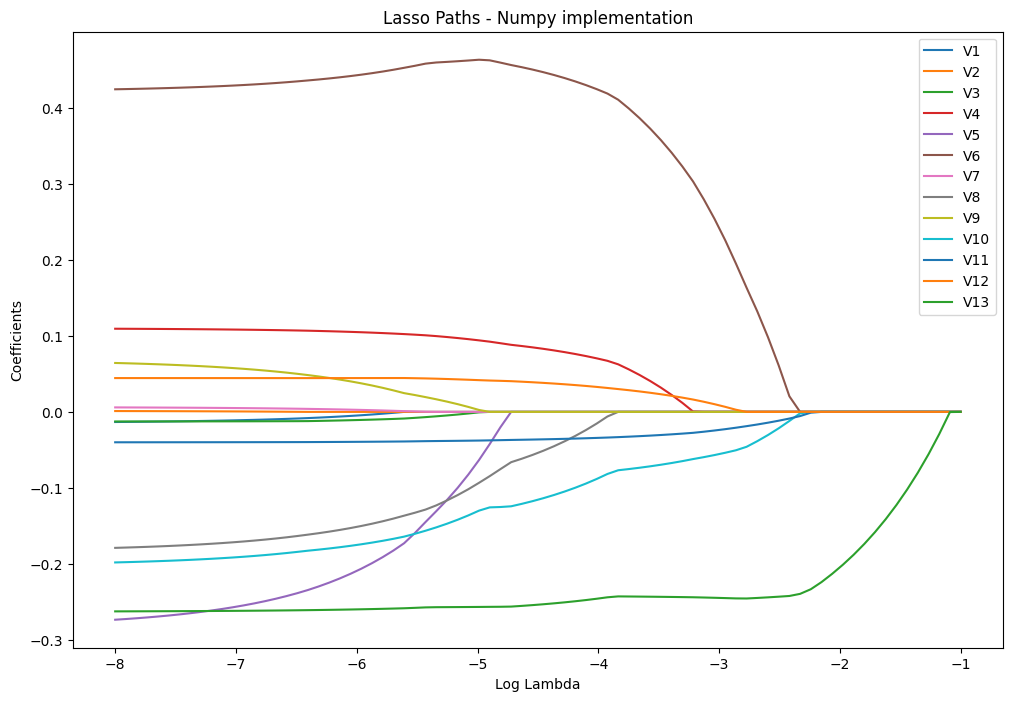

In [31]:
p, _ = myout.shape
plt.figure(figsize = (12,8))

for i in range(p-1):
    plt.plot(log_lam_seq, myout[i+1, :], label = var_names[i])

plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

true_coefs_df = pd.read_csv("https://liangfgithub.github.io/Data/Coding2_lasso_coefs.csv")
true_B = true_coefs_df.to_numpy()

# Compute the absolute differences
differences = np.abs(myout - true_B)

# Find the maximum difference
max_diff = np.max(differences)

print(f"Maximum difference between estimated and true coefficients: {max_diff:.6f}")



In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load the data
url = "https://liangfgithub.github.io/Data/Coding2_Data1.csv"
myData = pd.read_csv(url)

class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)

        for ifold in range(self.folds):
            train_inds = np.concatenate(index_sets[:ifold] + index_sets[ifold+1:])
            test_inds = index_sets[ifold]

            X_train = X.iloc[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X.iloc[test_inds, :])

            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] += cv_err[k] + np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = lm().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)


# Separate response and predictors
Y = myData['Y'].values
X = myData.drop(['Y'], axis=1).values  # Convert to NumPy arrays for efficiency

# Number of predictors
n_samples, n_features = X.shape
n_simulations = 50

# Define model functions

def lasso_alphas(X_train, Y_train):
    lasso_alphas = np.logspace(-10, 1, 100)
    lassocv = LassoCV(alphas = lasso_alphas, cv = 10)
    lassocv.fit(X_train, Y_train)
    lassocv.alpha_

    mean_mse = np.mean(lassocv.mse_path_, axis=1)
    std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10) 

    cv_alphas = lassocv.alphas_
    min_idx = np.argmin(mean_mse)

    alpha_min = cv_alphas[min_idx]

    threshold = mean_mse[min_idx] + std_mse[min_idx]
    alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])

    return alpha_min, alpha_1se 


def full_model(X_train, Y_train, X_test):
    full = lm().fit(X_train, Y_train)
    return mean_squared_error(Y_test, full.predict(X_test))

def ridge_min_model(X_train, Y_train, X_test):
    ridge_alphas = np.logspace(-10, 1, 100)
    ridgecv = RidgeCV(alphas = ridge_alphas, cv = 10, 
                  scoring = 'neg_mean_squared_error')
    ridgecv.fit(X_train, Y_train)
    ridge_model = Ridge(alpha = ridgecv.alpha_)
    ridge_model.fit(X_train, Y_train)
    return mean_squared_error(Y_test, ridge_model.predict(X_test))

def lasso_model(X_train, Y_train, X_test, alpha):
    lasso_model_min = Lasso(alpha = alpha, max_iter=10000)
    lasso_model_min.fit(X_train, Y_train)
    return mean_squared_error(Y_test, lasso_model_min.predict(X_test)), lasso_model_min

def lasso_model_refit(X_train, Y_train, X_test, model):
    nonzero_indices = np.where(model.coef_ != 0)[0]
    lm_refit = lm()
    lm_refit.fit(X_train.iloc[:, nonzero_indices], Y_train)
    return mean_squared_error(Y_test, lm_refit.predict(X_test.iloc[:, nonzero_indices]))


def pcr_model(X_train, Y_train, X_test):
    pcr = PCR()
    pcr.fit(X_train, Y_train)
    return mean_squared_error(Y_test, pcr.predict(X_test))

# Initialize a list to store MSPE results
results_list = []

cache_file = "/Users/jzeiders/Documents/Code/Learnings/GraduateML/src/Coding2/part2_a_cache.csv"

if os.path.exists(cache_file):
    print(f"Loading cached results from {cache_file}")
    results = pd.read_csv(cache_file, index_col=0)
else:
    # Number of simulations

    for i in range(n_simulations):
        # Split the data: 75% training, 25% testing
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=0.25, random_state=i
        )

        scaler = StandardScaler(with_mean=True, with_std=True)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)


        
        # Full Model
        mse_full = full_model(X_train, Y_train, X_test)
        
        # Ridge.min
        mse_ridge = ridge_min_model(X_train, Y_train, X_test)
        
        alpha_min, alpha_1se = lasso_alphas(X_train, Y_train)
        
        # Lasso.min and Lasso.1se
        mse_lasso_min, _ = lasso_model(X_train, Y_train, X_test, alpha_min)
        mse_lasso_1se, lasso_model_1se= lasso_model(X_train, Y_train, X_test, alpha_1se)
        
        
        # L.Refit
        mse_l_refit = lasso_model_refit(X_train, Y_train, X_test, lasso_model_1se)
        
        # PCR
        mse_pcr = pcr_model(X_train, Y_train, X_test)
        
        # Append the results
        results_list.append({
            'Full': mse_full,
            'Ridge.min': mse_ridge,
            'Lasso.min': mse_lasso_min,
            'Lasso.1se': mse_lasso_1se,
            'L.Refit': mse_l_refit,
            'PCR': mse_pcr
        })
        
        print(f"Simulation {i+1}/{n_simulations} completed.")

    # Convert the list of dictionaries to a DataFrame
    results = pd.DataFrame(results_list)

    results.to_csv(cache_file)

    # Display the first few rows of the results
    print(results.head())


Simulation 1/50 completed.
Simulation 2/50 completed.
Simulation 3/50 completed.
Simulation 4/50 completed.
Simulation 5/50 completed.
Simulation 6/50 completed.
Simulation 7/50 completed.
Simulation 8/50 completed.
Simulation 9/50 completed.
Simulation 10/50 completed.
Simulation 11/50 completed.
Simulation 12/50 completed.
Simulation 13/50 completed.
Simulation 14/50 completed.
Simulation 15/50 completed.
Simulation 16/50 completed.
Simulation 17/50 completed.
Simulation 18/50 completed.
Simulation 19/50 completed.
Simulation 20/50 completed.
Simulation 21/50 completed.
Simulation 22/50 completed.
Simulation 23/50 completed.
Simulation 24/50 completed.
Simulation 25/50 completed.
Simulation 26/50 completed.
Simulation 27/50 completed.
Simulation 28/50 completed.
Simulation 29/50 completed.
Simulation 30/50 completed.
Simulation 31/50 completed.
Simulation 32/50 completed.
Simulation 33/50 completed.
Simulation 34/50 completed.
Simulation 35/50 completed.
Simulation 36/50 completed.
S

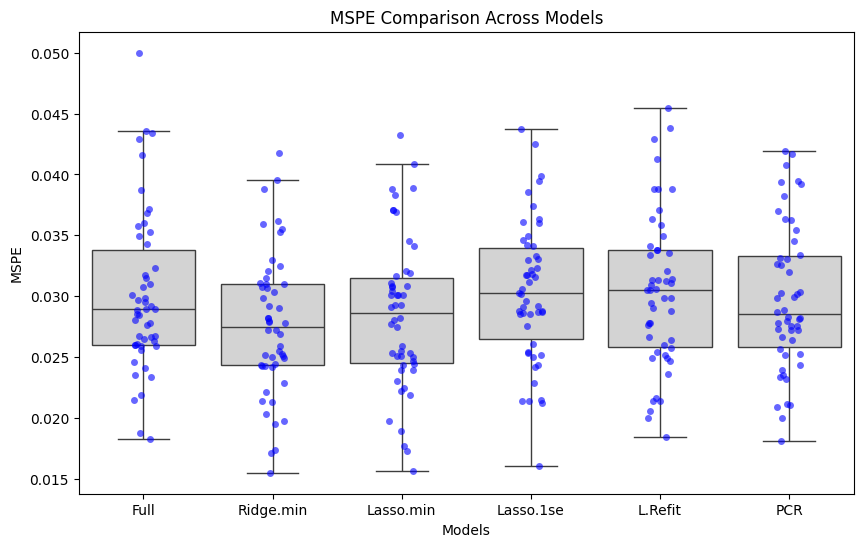

In [33]:
import seaborn as sns
# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Create the strip chart
sns.stripplot(data=results, jitter=True, color='blue', alpha=0.6)

# Overlay a boxplot for additional insights
sns.boxplot(data=results, whis=1.5, color='lightgray', fliersize=0)

# Label the chart
plt.title('MSPE Comparison Across Models')
plt.xlabel('Models')
plt.ylabel('MSPE')

# Show the plot
plt.show()

- Which procedure or procedures yield the best performance in terms of MSPE?

The best procedure is Ridge.min

– Conversely, which procedure or procedures show the poorest performance?
The wrost is Lassso refit

– In the context of Lasso regression, which procedure, Lasso.min or Lasso.1se, yields a better
MSPE?
Lasso Min yields a better results

– Is refitting advantageous in this case? In other words, does L.Refit outperform Lasso.1se?
Refitting performs slightly worse.
– Is variable selection or shrinkage warranted for this particular dataset? To clarify, do you find
the performance of the Full model to be comparable to, or divergent from, the best-performing
procedure among the other five?

Refitting is helpful, particularly ridge min regression.

In [34]:
results_list = []


cache_file = "/Users/jzeiders/Documents/Code/Learnings/GraduateML/src/Coding2/part2_b_cache.csv"
url = "https://liangfgithub.github.io/Data/Coding2_Data2.csv"
myData = pd.read_csv(url)

# Separate response and predictors
Y = myData['Y'].values
X = myData.drop(['Y'], axis=1).values  # Convert to NumPy arrays for efficiency

# Number of predictors
n_samples, n_features = X.shape

if os.path.exists(cache_file):
    print(f"Loading cached results from {cache_file}")
    results = pd.read_csv(cache_file, index_col=0)
else:
    # Number of simulations
    for i in range(n_simulations):
        # Split the data: 75% training, 25% testing
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=0.25, random_state=i
        )

        scaler = StandardScaler(with_mean=True, with_std=True)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)

        # Ridge.min
        mse_ridge = ridge_min_model(X_train, Y_train, X_test)
        
        alpha_min, alpha_1se = lasso_alphas(X_train, Y_train)
        
        # Lasso.min and Lasso.1se
        mse_lasso_min, _ = lasso_model(X_train, Y_train, X_test, alpha_min)
        mse_lasso_1se, lasso_model_1se= lasso_model(X_train, Y_train, X_test, alpha_1se)
        
        
        # L.Refit
        mse_l_refit = lasso_model_refit(X_train, Y_train, X_test, lasso_model_1se)
        
        # PCR
        mse_pcr = pcr_model(X_train, Y_train, X_test)
        
        # Append the results
        results_list.append({
            'Ridge.min': mse_ridge,
            'Lasso.min': mse_lasso_min,
            'Lasso.1se': mse_lasso_1se,
            'L.Refit': mse_l_refit,
            'PCR': mse_pcr
        })
        
        print(f"Simulation {i+1}/{n_simulations} completed.")

    # Convert the list of dictionaries to a DataFrame
    results = pd.DataFrame(results_list)

    results.to_csv(cache_file)

    # Display the first few rows of the results
    print(results.head())


Simulation 1/50 completed.
Simulation 2/50 completed.
Simulation 3/50 completed.
Simulation 4/50 completed.
Simulation 5/50 completed.
Simulation 6/50 completed.
Simulation 7/50 completed.
Simulation 8/50 completed.
Simulation 9/50 completed.
Simulation 10/50 completed.
Simulation 11/50 completed.
Simulation 12/50 completed.
Simulation 13/50 completed.
Simulation 14/50 completed.
Simulation 15/50 completed.
Simulation 16/50 completed.
Simulation 17/50 completed.
Simulation 18/50 completed.
Simulation 19/50 completed.
Simulation 20/50 completed.
Simulation 21/50 completed.
Simulation 22/50 completed.
Simulation 23/50 completed.
Simulation 24/50 completed.
Simulation 25/50 completed.
Simulation 26/50 completed.
Simulation 27/50 completed.
Simulation 28/50 completed.


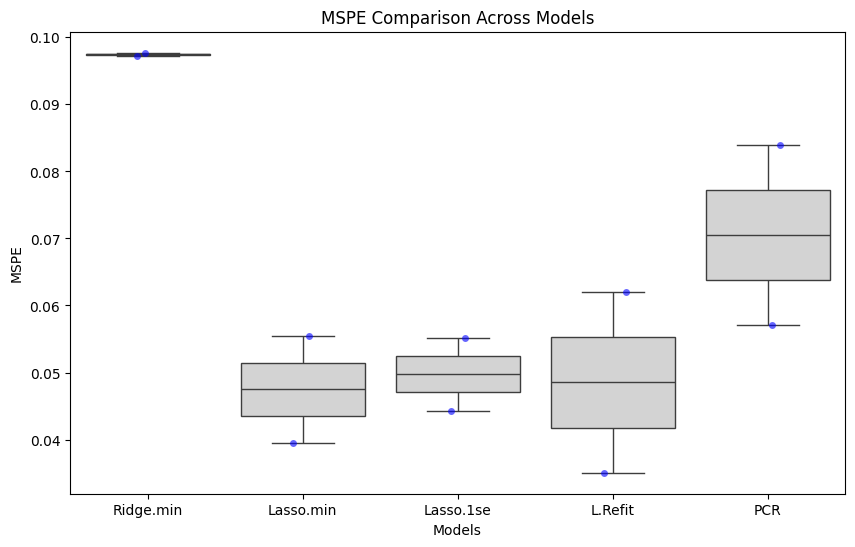

In [ ]:
import seaborn as sns
# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Create the strip chart
sns.stripplot(data=results, jitter=True, color='blue', alpha=0.6)

# Overlay a boxplot for additional insights
sns.boxplot(data=results, whis=1.5, color='lightgray', fliersize=0)

# Label the chart
plt.title('MSPE Comparison Across Models')
plt.xlabel('Models')
plt.ylabel('MSPE')

# Show the plot
plt.show()